# Landmark Tracker

Made by <a href="https://github.com/SeanvonB">SeanvonB</a> | <a href="https://github.com/SeanvonB/landmark-tracker">Source</a>

This was my final for Udacity's [Computer Vision Nanodegree](https://www.udacity.com/course/computer-vision-nanodegree--nd891), which I completed in 2020. Unlike the other projects, this one doesn't really produce a standalone piece of software; rather, this notebook demonstrates a mathematical solution to the [Simultaneous Localization and Mapping](https://en.wikipedia.org/wiki/Simultaneous_localization_and_mapping) (SLAM) problem; or, how can an autonomous agent (i.e. robot) simultaneously explore an unknown environment and keep track of itself within that unknown? I'll give you a hint: it will involve some real Greek letter math, and maybe even some LaTeX – how exciting!

Udacity originally divided this project into three sections:
1. Moving and Sensing
2. Omega and Xi
3. Landmark Detection and Tracking

Note: this project was created by Udacity in 2018 and completed by me in 2020, based on research from 2005; so, by the time you read this, there's no telling how outdated this approach may be.

# 1.0 Moving and Sensing

Computer vision and movement always have a degree of uncertainty to them – reality is simply too busy to account for everything while still maintaining reasonable computational performance. Udacity provided this excellent example: 

>Imagine a car driving uphill and downhill; the speedometer reading will likely overestimate the speed of the car going up hill and underestimate the speed of the car going down hill because it cannot perfectly account for gravity. Similarly, we cannot perfectly predict the *motion* of a robot. A robot is likely to slightly overshoot or undershoot a target location.

Throughout this notebook, I'll frequently refer to this concept of uncertainty, which will typically appear in the form of measured ranges rather than concrete measurements. There will be a good example of this momentarily when I define and initialize the `robot` class, which the following code cells do:

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
# Define robot
class robot:

    # --------
    # init: 
    #   creates a robot with the specified parameters and initializes 
    #   the location (self.x, self.y) to the center of the world
    #
    def __init__(self, world_size = 100.0, measurement_range = 30.0,
                 motion_noise = 1.0, measurement_noise = 1.0):
        self.measurement_noise = 0.0
        self.world_size = world_size
        self.measurement_range = measurement_range
        self.x = world_size / 2.0
        self.y = world_size / 2.0
        self.motion_noise = motion_noise
        self.measurement_noise = measurement_noise
        self.landmarks = []
        self.num_landmarks = 0


    # Returns random positive float
    def rand(self):
        return random.random() * 2.0 - 1.0


    # --------
    # move: attempts to move robot by dx, dy. If outside world
    #       boundary, then the move does nothing and instead returns failure
    #
    def move(self, dx, dy):

        x = self.x + dx + self.rand() * self.motion_noise
        y = self.y + dy + self.rand() * self.motion_noise

        if x < 0.0 or x > self.world_size or y < 0.0 or y > self.world_size:
            return False
        else:
            self.x = x
            self.y = y
            return True
    

    # --------
    # sense: returns x- and y- distances to landmarks within visibility range
    #        because not all landmarks may be in this range, the list of measurements
    #        is of variable length. Set measurement_range to -1 if you want all
    #        landmarks to be visible at all times
    #
    def sense(self):
        ''' This function does not take in any parameters; instead, it references internal
            variables (such as self.landamrks) to measure the distance between the robot and
            any landmarks that the robot can see (i.e. within measurement range).
            This function returns a list of landmark indices, measured distances (dx, dy),
            between the robot's position and said landmarks.
            This function accounts for measurement_noise and measurement_range.
            '''
           
        measurements = []
        
        for i, landmark in enumerate(self.landmarks):
        
            # For each landmark:
            # 1. Compute dx, dy
            # 2. Account for measurement noise by adding noise component to dx, dy
            # 3. If within range, add landmark to measurements list
            dx = self.x - landmark[0] + (self.rand() * self.measurement_noise)
            dy = self.y - landmark[1] + (self.rand() * self.measurement_noise)
            if (abs(dx) < self.measurement_range) and (abs(dy) < self.measurement_range):
                measurements.append([i, dx, dy])
        
        return measurements

    
    # --------
    # make_landmarks: 
    # make random landmarks located in the world
    #
    def make_landmarks(self, num_landmarks):
        self.landmarks = []
        for i in range(num_landmarks):
            self.landmarks.append([round(random.random() * self.world_size),
                                   round(random.random() * self.world_size)])
        self.num_landmarks = num_landmarks
    
    
    # Called when print(robot) is called; prints robot location
    def __repr__(self):
        return 'Robot: [x=%.5f y=%.5f]'  % (self.x, self.y)

## 1.1 Creating the Robot

The next cell instantiates a copy of the `robot` object inside its own tiny 10x10 world. You might ask, *"10x10 of what units?"* – Udacity never specified, so I think we can decide. I like to imagine centimeters, so the robot can be tiny and cute. But you can imagine kilometers if you would rather live your mecha fantasy instead. Either way, this world will be sufficient for learning how the robot works, but future tests will use worlds that are at least 100x100 imaginary 2D space units.

Welcome to loaded memory, little guy! Anthropomorphising the data object is optional but recommended.

In [3]:
world_size         = 10.0    # size of world (square)
measurement_range  = 5.0     # range at which we can sense landmarks
motion_noise       = 0.2     # noise in robot motion
measurement_noise  = 0.2     # noise in the measurements

# Instantiate robot, `r`
r = robot(world_size, measurement_range, motion_noise, measurement_noise)

# Print location of `r`
print(r)

Robot: [x=5.00000 y=5.00000]


## 1.2 Visualizing the World

For our benefit, Udacity provided a `display_world` function in their `helpers.py` package. But, to be clear, the robot doesn't see the world as this function shows it. This visualization is for human understanding and for assessing the robot. The robot can only see `measurement_range` units in any direction.

In the example below, the robot is in the middle of a 10x10 world at (x, y) = (5.0, 5.0), marked by the red `O`:

Robot: [x=5.00000 y=5.00000]


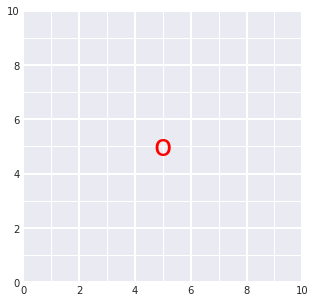

In [4]:
# Import helper function
from helpers import display_world

# Define figure size
plt.rcParams["figure.figsize"] = (5,5)

# Print robot coords and display robot/world
print(r)
display_world(int(world_size), [r.x, r.y])

## 1.3 Moving the Robot

Moving the robot is easy with the `.move()` method, so I'll move the robot 1 unit right and 2 units up. Where is the robot now?

Well, it probably won't be at `Robot: [x=6.00000 y=7.00000]` due to the aforementioned **uncertainty**. But, with an assigned `motion_noise` of `0.2`, the robot should be somewhere within 0.2 units of the desired position. That's not so bad. However, subsequent movements will only compound that uncertainty; and, pretty soon, the robot will have better luck nagivating by bumping into boundaries than by using the tracking system – not a good look for a robot who dreams of someday becoming an autonomous vehicle.

The robot thinks it's at ***(6, 7)***, but the following shows the true location:

Robot: [x=6.07092 y=6.84326]


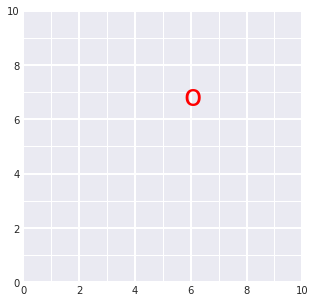

In [5]:
# Choose pos or neg values of dx, dy
dx = 1
dy = 2
r.move(dx, dy)

# Print exact location
print(r)

# Display world after movement
display_world(int(world_size), [r.x, r.y])

## 1.4 Creating Landmarks

In this instance, "landmarks" are anything visible and stationary within the robot's world. If you're imagining a giant robot, they might be buildings; if you're imagining a tiny robot, they might be the debris on your desk. Regardless, landmarks are **stationary**. They'll each appear as a purple `X` on the grid for the purpose of visualization.

The same package that includes `display_world` also includes a `make_landmarks` function. This function generates and randomly distributes the specified number of landmarks in the world of the robot on which it is called. They're stored on the robot in `r.landmarks`, but that's because the robot and the world associated with it are the same object – the robot doesn't automatically know where they are and must still locate them.

The following will create those landmarks:

Robot: [x=6.07092 y=6.84326]


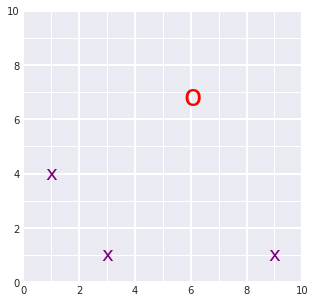

Landmark locations [x,y]:  [[3, 1], [1, 4], [9, 1]]


In [6]:
# Create landmarks
num_landmarks = 3
r.make_landmarks(num_landmarks)

# Print exact location of robot
print(r)

# Display world including landmarks
display_world(int(world_size), [r.x, r.y], r.landmarks)

# Print exact location of landmarks
print('Landmark locations [x,y]: ', r.landmarks)

## 1.5 Sense the Landmarks

Now that there are a few landmarks for the robot to find, I needed to create the `sense` function, found in the `robot_class.py` file, for the robot to find them. The `sense` function must be limited by the robot's `measurement_range` and modified by its `measurement_noise` value; otherwise, it gives the robot fairly accurate information about the distance between a landmark and itself. This information is stored in an `[i, dx, dy]` list, where `i` is the landmark's index within its own list, and `dx`, `dy` are the distances.

In the following cell, the robot can only `sense` the second landmark, because the others are outside `measurement_range`:

In [7]:
# try to sense any surrounding landmarks
measurements = r.sense()

# this will print out an empty list if `sense` has not been implemented
print(measurements)

[[1, 4.940058526952017, 3.0072971134414193]]


## 1.6 Data

Most of what I've done so far is "data"... but `data` will be an array on the robot object that stores specific pairs of lists: movements, and measurements. Solving the problem of SLAM will be when the robot can successfully do what I've done so far but backwards: it'll sense the surroundings, move, and repeat. If the robot can reconstruct the world, it will be a success. That's where the robot's `data` comes in. Over the next section, I'll use this array to form constraint matrics and vectors and implement SLAM.


Here is `data` being constructed, which you'll notice happens over a series of time steps:

In [8]:
data = []

# One `sense` measurement + one `move` motion = one `time_step` 
time_step = 0

# Each time step, the following update occurs
data.append([measurements, [dx, dy]])

# Print example
print(data)

[[[[1, 4.940058526952017, 3.0072971134414193]], [1, 2]]]


In [9]:
# Measurements are accessed like this
print('Measurements: ', data[time_step][0])

# Motions like this
print('Motion: ', data[time_step][1])

Measurements:  [[1, 4.940058526952017, 3.0072971134414193]]
Motion:  [1, 2]


# 2.0 Omega and Xi

*Note: apparently, the robot's location ought to be called a **pose** ("and pose and pose and pose"), while **location** refers to landmark locations.*

In Graph SLAM, the Greek letter **Ω** or **omega** represents a 2D matrix of robot **poses** (`[Pxi, Pyi]`) and landmarks (`[Lxi, Lyi]`), while the letter **ξ** or **xi** represents a 1D vector of relational data.

For the uninitiated, these objects look like this:

<img src='images/omega_xi.png' width="100%" height="auto" style="max-width: 400px;">

Now, here's another example that depicts an initial state with three poses, constraints provided:

<img src='images/omega_xi_constraints.png' width="100%" height="auto" style="max-width: 960px;" />

But there are still plenty of unknown `x` values. Graph SLAM represents these as **μ** or **mu** – yup, another Greek letter – which equals **Ω**<sup>-1</sup> * **xi**.

<img src='images/solution.png' width="100%" height="auto" style="max-width: 540px;" />

The following cell demonstrates this assertion if you don't wanna just be cool and believe me:


In [1]:
import numpy as np

# Define omega and xi as above
omega = np.array([[1,0,0],
                  [-1,1,0],
                  [0,-1,1]])

xi = np.array([[-3],
               [5],
               [3]])

# Calculate inverse of omega
omega_inv = np.linalg.inv(np.matrix(omega))

# Calculate mu
mu = omega_inv*xi

# Print values of mu (x0, x1, x2)
print(mu)

[[-3.]
 [ 2.]
 [ 5.]]


## 2.1 Motion Constraints and Landmarks

But I can't just make up my own constraints; so, from now on, I'll have to calculate them myself and populate omega and xi with actual data. Let's wipe the slate:

<img src='images/initial_constraints.png' width="100%" height="auto" style="max-width: 540px;" />

This example now also includes landmarks. If the pose displacement from `x0` to `x1` has a `dx` displacement of `5`, then that's the motion constraint that relates x0 to x1.

<img src='images/motion_constraints.png' width="100%" height="auto" style="max-width: 540px;" />

But the motion constraint that relates the pose at `x0` to `x1` by a value of `5` will affect the rest of the matrix, adding values for everything that relates to `x0` and `x1`.

Now, what about `y`? Yeah, I'll have to do this again for the y-dimension. See you in **Part 3**!

# 3.0 Implement SLAM 

To reiterate what I said in the introduction, SLAM is the problem of how an autonomous agent (i.e. robot) can simultaneously explore an unknown environment while also keeping track of itself within that unfamiliar space. It's a chicken-and-egg scenario, but one that needs to be solved for fully-autonomous vehicles to become a reality. The solution for this problem will be a system for both localizing the robot and generating a map of its environment as the robot both moves and senses in real-time – *simultaneously* is the key word, here, because neither of the stated objectives can depend on the other already being complete.

That said, this problem has both already been solved and remains an active area of research, as new solutions bring increasingly signficant advantages. I will not be creating a fresh solution; I am simply implementing a solution known as [Graph SLAM](http://robots.stanford.edu/papers/thrun.graphslam.pdf), which was an early solution created by Udacity founder and my Computer Vision instructor, Sebastian Thrun.

On the surface, the totality of this assignment sounds simple: "define a function, `slam`, which takes in six parameters as input and returns the vector `mu`."

No problem, right? Let's get into it...

## 3.1 Create the World

*And in the 23nd cell, Sean said, "Let there be a world of size 100x100 unspecified units with 5 featureless landmarks"; and it was so. And Sean saw that it was fine.*

In [1]:
import numpy as np
from helpers import make_data

# World parameters
num_landmarks      = 5        # number of landmarks (duh)
N                  = 20       # time steps
world_size         = 100.0    # size of world, square

# Robot parameters
measurement_range  = 50.0     # max distance for landmarks to be sensed
motion_noise       = 2.0      # noise in robot motion
measurement_noise  = 2.0      # noise in sense measurements
distance           = 20.0     # distanced moved per iteration before noise


# The `make_data` function instantiates a robot AND generates random landmarks for a given world_size and num_landmarks
data = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)

 
Landmarks:  [[75, 84], [75, 21], [75, 27], [74, 47], [97, 57]]
Robot: [x=86.33310 y=54.87670]


## 3.2 The `make_data` Function

The following is documentation on the `make_data` function provided by Udacity:

>The function above, `make_data`, takes in so many world and robot motion/sensor parameters because it is responsible for:
>1. Instantiating a robot (using the robot class)
>2. Creating a grid world with landmarks in it
>
>**This function also prints out the true location of landmarks and the *final* robot location, which you should refer back to when you test your implementation of SLAM.**
>
>The `data` this returns is an array that holds information about **robot sensor measurements** and **robot motion** `(dx, dy)` that is collected over a number of time steps, `N`. You will have to use *only* these readings about motion and measurements to track a robot over time and find the determine the location of the landmarks using SLAM. We only print out the true landmark locations for comparison, later.
>
>
>In `data` the measurement and motion data can be accessed from the first and second index in the columns of the data array. See the following code for an example, where `i` is the time step:
>```
>measurement = data[i][0]
>motion = data[i][1]
>```

In [2]:
# Print measurement and motion stats
time_step = 0

print('Example measurements: \n', data[time_step][0])
print('\n')
print('Example motion: \n', data[time_step][1])

Example measurements: 
 [[0, -24.579515484738458, -34.52759375228065], [1, -24.2792282568213, 29.71044984603075], [2, -26.310935685770875, 21.253039054282638], [3, -23.979582379282572, 1.3536489287480848], [4, -47.59194704520605, -7.549642197602989]]


Example motion: 
 [-8.989826295407736, -17.86569403013484]


## 3.3 Initialize Omega and Xi

Solving this problem in the first place must have been difficult. But, in this project, the most difficult part will probably be maintaining and updating the constraints, omega matrix and xi vector, without anyone getting flipped around or corrupted. There are a couple different ways to approach tackle this, but I chose the following:

In [3]:
def initialize_constraints(N, num_landmarks, world_size):
    ''' This function returns initialized constraint matrices, omega and xi.'''

    ## Define size (x + y per N + num_landmarks) of constraint matrix
    size = (N + num_landmarks) * 2

    ## Define constraint matrix, omega
    omega = np.zeros((size, size))
    omega[0][0] = 1
    omega[1][1] = 1

    ## Define constraint vector, xi
    xi = np.zeros((size, 1))
    xi[0] = world_size / 2
    xi[1] = world_size / 2

    return omega, xi

## 3.4 Test the Initialization

Ultimately, I'll need a process for testing and visualizing the results of my SLAM implementation, so why not test my `initialize_contraints` with Udacity's suggested solution, which uses [seaborn](https://seaborn.pydata.org/) for data visualization? Sure, the results won't be fascinating yet, but I'll at least know whether or not the pipe leaks.

In [4]:
# Import packages
import matplotlib.pyplot as plt
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

In [5]:
N_test = 5
num_landmarks_test = 2
small_world = 10

# Initialize constraints
initial_omega, initial_xi = initialize_constraints(N_test, num_landmarks_test, small_world)

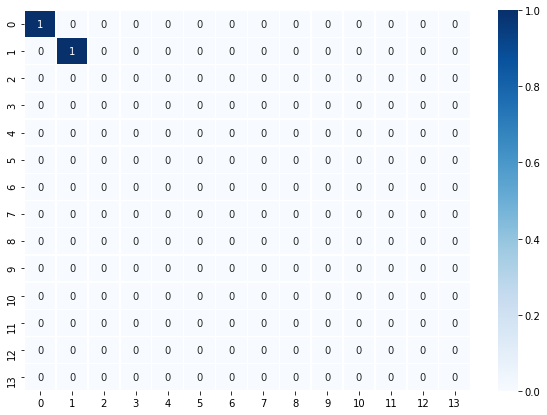

In [6]:
# Define chart size
plt.rcParams["figure.figsize"] = (10,7)

# Display omega chart
sns.heatmap(DataFrame(initial_omega), cmap='Blues', annot=True, linewidths=.5)

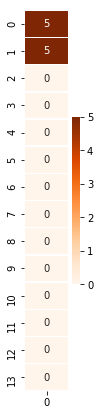

In [7]:
# Define chart size
plt.rcParams["figure.figsize"] = (1,7)

# Display xi chart
sns.heatmap(DataFrame(initial_xi), cmap='Oranges', annot=True, linewidths=.5)

## 3.5 Implement Graph SLAM

Per the rubric:
>In addition to `data`, your slam function will also take in:
>* N -   The number of time steps that a robot will be moving and sensing
>* num_landmarks - The number of landmarks in the world
>* world_size - The size (w/h) of your world
>* motion_noise - The noise associated with motion; the update confidence for motion should be `1.0/motion_noise`
>* measurement_noise - The noise associated with measurement/sensing; the update weight for measurement should be `1.0/measurement_noise`

Plus, the only real goal is an accurate `mu`, calculated like so:	$\mu = \Omega^{-1}\xi$


With these requirements in mind, I'm jumping into implementation with the following cell:

In [8]:
## First, I know `slam` must take in 6 arguments and return `mu` 
def slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise):
    
    # Second, I have what I need to initialize constraints, so I'll do so
    omega, xi = initialize_constraints(N, num_landmarks, world_size)
    
    # Third, I can iterate through each `N` of `data`...  
    for i, (next_measure, next_motion) in enumerate(data):
        for lm_i, lm_x, lm_y in next_measure:
            
            # ... and update the constraint matrix/vector for MEASUREMENTS
            omega[2 * i, 2 * i] += 1 / measurement_noise
            omega[2 * i, 2 * (N + lm_i)] -= 1 / measurement_noise
            omega[2 * (N + lm_i), 2 * i] -= 1 / measurement_noise
            omega[2 * (N + lm_i), 2 * (N + lm_i)] += 1 / measurement_noise

            omega[2 * i + 1, 2 * i + 1] += 1 / measurement_noise
            omega[2 * i + 1, 2 * (N + lm_i) + 1] -= 1 / measurement_noise
            omega[2 * (N + lm_i) + 1, 2 * i + 1] -= 1 / measurement_noise
            omega[2 * (N + lm_i) + 1, 2 * (N + lm_i) + 1] += 1 / measurement_noise

            xi[2 * i] -= lm_x / measurement_noise
            xi[2 * (N + lm_i)] += lm_x / measurement_noise

            xi[2 * i + 1] -= lm_y / measurement_noise
            xi[2 * (N + lm_i) + 1] += lm_y / measurement_noise
        
        # ... and update the constraint matrix/vector for MOTION
        motion_x, motion_y = next_motion
        omega[2 * i:2 * i + 4, 2 * i:2 * i + 4] += (1 / motion_noise) * np.array([[1, 0, -1, 0],
                                                                                  [0, 1, 0, -1],
                                                                                  [-1, 0, 1, 0],
                                                                                  [0, -1, 0, 1]])
        xi[2 * i:2 * i + 4] += (1 / motion_noise) * np.array([[-motion_x],
                                                              [-motion_y],
                                                              [motion_x],
                                                              [motion_y]])
        
    
    # Finally, calculate `mu` according to the formula
    mu = np.linalg.inv(np.matrix(omega)) * xi
    
    return mu

## 3.6 Helper Functions

Udacity then provided the following helper functions to display the estimated pose and landmark locations that my implementation production:

In [9]:
# Helper function that creates list of poses and landmarks for easier printing
def get_poses_landmarks(mu, N):
    # Create list of poses
    poses = []
    for i in range(N):
        poses.append((mu[2*i].item(), mu[2*i+1].item()))

    # Create list of landmarks
    landmarks = []
    for i in range(num_landmarks):
        landmarks.append((mu[2*(N+i)].item(), mu[2*(N+i)+1].item()))

    # Return lists
    return poses, landmarks

In [10]:
def print_all(poses, landmarks):
    print('\n')
    print('Estimated Poses:')
    for i in range(len(poses)):
        print('['+', '.join('%.3f'%p for p in poses[i])+']')
    print('\n')
    print('Estimated Landmarks:')
    for i in range(len(landmarks)):
        print('['+', '.join('%.3f'%l for l in landmarks[i])+']')

## 3.7 Run SLAM

With the above helper functions, and I run the `slam` function that I defined and see the results as two lists:
>1. **Estimated poses**, a list of (x, y) pairs that is exactly `N` in length since this is how many motions your robot has taken. The very first pose should be the center of your world, i.e. `[50.000, 50.000]` for a world that is 100.0 in square size.
>2. **Estimated landmarks**, a list of landmark positions (x, y) that is exactly `num_landmarks` in length. 

I'll know how I did by comparing the following values to the true values printed above, but remember that there should be a small amount of variance due to noise.

Here goes:

In [11]:
mu = slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise)

# Print resulting landmarks and poses
if(mu is not None):
    poses, landmarks = get_poses_landmarks(mu, N)
    print_all(poses, landmarks)



Estimated Poses:
[50.000, 50.000]
[56.397, 57.802]
[60.516, 61.195]
[52.489, 55.913]
[44.462, 50.632]
[36.435, 45.351]
[47.824, 37.366]
[64.487, 23.350]
[49.118, 45.981]
[56.691, 44.835]
[64.265, 43.689]
[66.611, 51.746]
[61.064, 58.142]
[50.144, 56.576]
[35.943, 47.776]
[20.312, 35.276]
[8.983, 23.390]
[5.888, 18.943]
[4.331, 17.050]
[0.954, -2.663]


Estimated Landmarks:
[23.022, 15.412]
[21.193, 68.823]
[20.291, 62.717]
[22.252, 47.609]
[1.115, 40.011]


## 3.8 Visualize the World

Finally, I can visualize the world printed above using the `display_world` code from the `helpers.py` file provided by Udacity:

Last pose:  (0.9541786620258961, -2.6629774645488027)


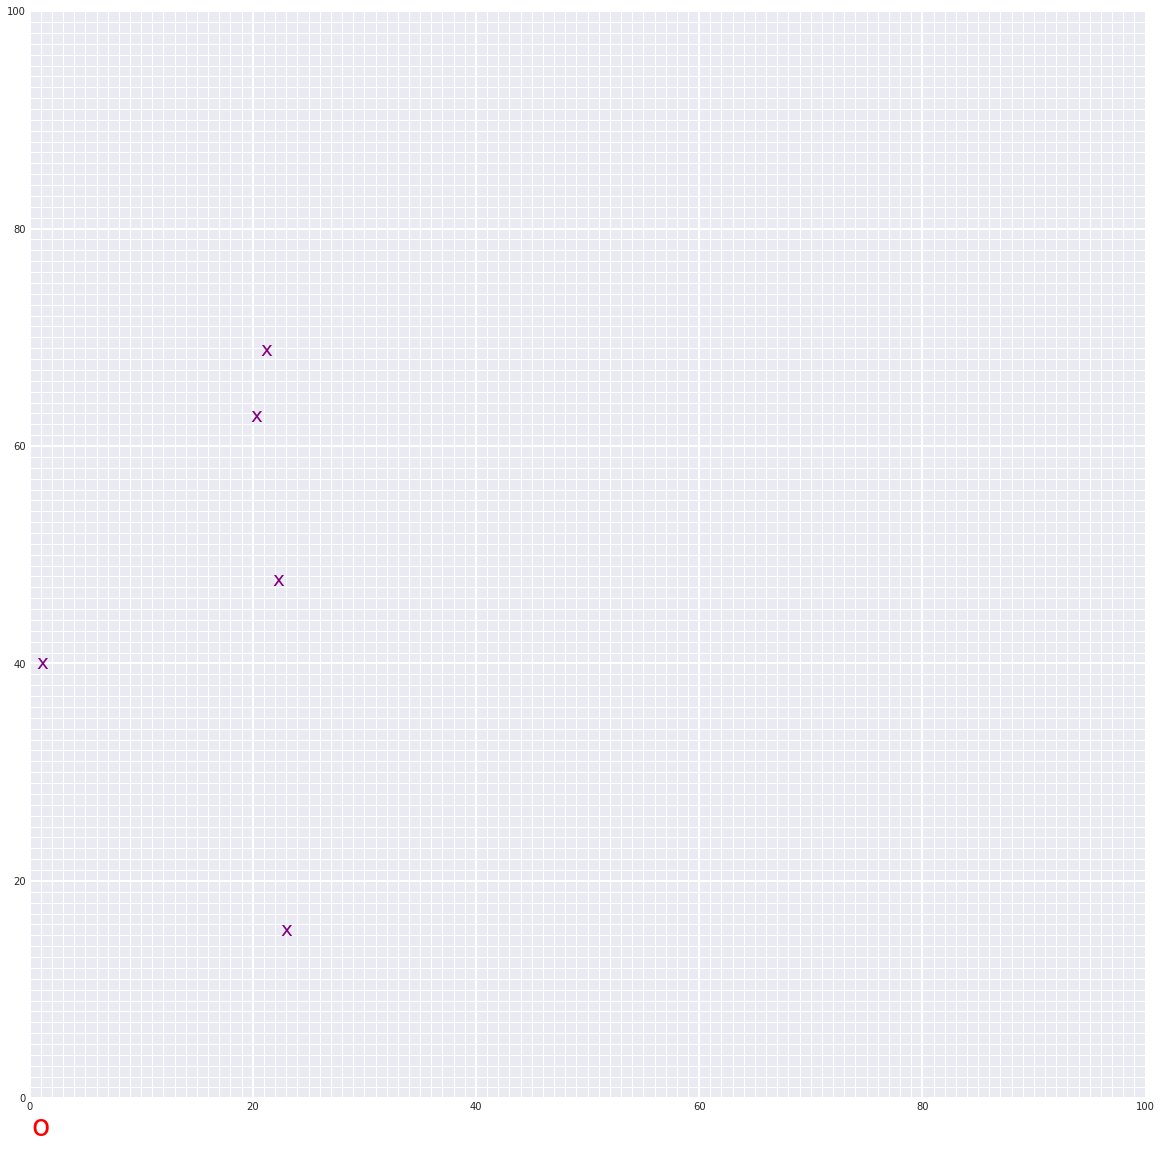

In [12]:
from helpers import display_world

# Define figure size
plt.rcParams["figure.figsize"] = (20,20)

# Check if poses has been created
if 'poses' in locals():
    # Print last pose
    print('Last pose: ', poses[-1])
    # Display last position of robot *and* all landmark positions
    display_world(int(world_size), poses[-1], landmarks)

## 3.9 Further Testing

Not bad! Although, in the final run, I'm not sure what caused the robot to finish out of bounds – given how its behavior is defined, that shouldn't be possible, so I wonder whether this might be a glitch in visualization rather than in the robot itself. Either way, the numbers look good, at least!

Udacity provided a couple more test sets for confirmation, which I'll run and leave for you to examine:

In [13]:
# Here is the data and estimated outputs for Test Case 1

test_data1 = [[[[1, 19.457599255548065, 23.8387362100849], [2, -13.195807561967236, 11.708840328458608], [3, -30.0954905279171, 15.387879242505843]], [-12.2607279422326, -15.801093326936487]], [[[2, -0.4659930049620491, 28.088559771215664], [4, -17.866382374890936, -16.384904503932]], [-12.2607279422326, -15.801093326936487]], [[[4, -6.202512900833806, -1.823403210274639]], [-12.2607279422326, -15.801093326936487]], [[[4, 7.412136480918645, 15.388585962142429]], [14.008259661173426, 14.274756084260822]], [[[4, -7.526138813444998, -0.4563942429717849]], [14.008259661173426, 14.274756084260822]], [[[2, -6.299793150150058, 29.047830407717623], [4, -21.93551130411791, -13.21956810989039]], [14.008259661173426, 14.274756084260822]], [[[1, 15.796300959032276, 30.65769689694247], [2, -18.64370821983482, 17.380022987031367]], [14.008259661173426, 14.274756084260822]], [[[1, 0.40311325410337906, 14.169429532679855], [2, -35.069349468466235, 2.4945558982439957]], [14.008259661173426, 14.274756084260822]], [[[1, -16.71340983241936, -2.777000269543834]], [-11.006096015782283, 16.699276945166858]], [[[1, -3.611096830835776, -17.954019226763958]], [-19.693482634035977, 3.488085684573048]], [[[1, 18.398273354362416, -22.705102332550947]], [-19.693482634035977, 3.488085684573048]], [[[2, 2.789312482883833, -39.73720193121324]], [12.849049222879723, -15.326510824972983]], [[[1, 21.26897046581808, -10.121029799040915], [2, -11.917698965880655, -23.17711662602097], [3, -31.81167947898398, -16.7985673023331]], [12.849049222879723, -15.326510824972983]], [[[1, 10.48157743234859, 5.692957082575485], [2, -22.31488473554935, -5.389184118551409], [3, -40.81803984305378, -2.4703329790238118]], [12.849049222879723, -15.326510824972983]], [[[0, 10.591050242096598, -39.2051798967113], [1, -3.5675572049297553, 22.849456408289125], [2, -38.39251065320351, 7.288990306029511]], [12.849049222879723, -15.326510824972983]], [[[0, -3.6225556479370766, -25.58006865235512]], [-7.8874682868419965, -18.379005523261092]], [[[0, 1.9784503557879374, -6.5025974151499]], [-7.8874682868419965, -18.379005523261092]], [[[0, 10.050665232782423, 11.026385307998742]], [-17.82919359778298, 9.062000642947142]], [[[0, 26.526838150174818, -0.22563393232425621], [4, -33.70303936886652, 2.880339841013677]], [-17.82919359778298, 9.062000642947142]]]


# Estimated Pose(s):
#     [50.000, 50.000]
#     [37.858, 33.921]
#     [25.905, 18.268]
#     [13.524, 2.224]
#     [27.912, 16.886]
#     [42.250, 30.994]
#     [55.992, 44.886]
#     [70.749, 59.867]
#     [85.371, 75.230]
#     [73.831, 92.354]
#     [53.406, 96.465]
#     [34.370, 100.134]
#     [48.346, 83.952]
#     [60.494, 68.338]
#     [73.648, 53.082]
#     [86.733, 38.197]
#     [79.983, 20.324]
#     [72.515, 2.837]
#     [54.993, 13.221]
#     [37.164, 22.283]


# Estimated Landmarks:
#     [82.679, 13.435]
#     [70.417, 74.203]
#     [36.688, 61.431]
#     [18.705, 66.136]
#     [20.437, 16.983]


# Test
mu_1 = slam(test_data1, 20, 5, 100.0, 2.0, 2.0)
poses, landmarks = get_poses_landmarks(mu_1, 20)
print_all(poses, landmarks)



Estimated Poses:
[50.000, 50.000]
[37.973, 33.652]
[26.185, 18.155]
[13.745, 2.116]
[28.097, 16.783]
[42.384, 30.902]
[55.831, 44.497]
[70.857, 59.699]
[85.697, 75.543]
[74.011, 92.434]
[53.544, 96.454]
[34.525, 100.080]
[48.623, 83.953]
[60.197, 68.107]
[73.778, 52.935]
[87.132, 38.538]
[80.303, 20.508]
[72.798, 2.945]
[55.245, 13.255]
[37.416, 22.317]


Estimated Landmarks:
[82.956, 13.539]
[70.495, 74.141]
[36.740, 61.281]
[18.698, 66.060]
[20.635, 16.875]


In [14]:
# Here is the data and estimated outputs for Test Case 2

test_data2 = [[[[0, 26.543274387283322, -6.262538160312672], [3, 9.937396825799755, -9.128540360867689]], [18.92765331253674, -6.460955043986683]], [[[0, 7.706544739722961, -3.758467215445748], [1, 17.03954411948937, 31.705489938553438], [3, -11.61731288777497, -6.64964096716416]], [18.92765331253674, -6.460955043986683]], [[[0, -12.35130507136378, 2.585119104239249], [1, -2.563534536165313, 38.22159657838369], [3, -26.961236804740935, -0.4802312626141525]], [-11.167066095509824, 16.592065417497455]], [[[0, 1.4138633151721272, -13.912454837810632], [1, 8.087721200818589, 20.51845934354381], [3, -17.091723454402302, -16.521500551709707], [4, -7.414211721400232, 38.09191602674439]], [-11.167066095509824, 16.592065417497455]], [[[0, 12.886743222179561, -28.703968411636318], [1, 21.660953298391387, 3.4912891084614914], [3, -6.401401414569506, -32.321583037341625], [4, 5.034079343639034, 23.102207946092893]], [-11.167066095509824, 16.592065417497455]], [[[1, 31.126317672358578, -10.036784369535214], [2, -38.70878528420893, 7.4987265861424595], [4, 17.977218575473767, 6.150889254289742]], [-6.595520680493778, -18.88118393939265]], [[[1, 41.82460922922086, 7.847527392202475], [3, 15.711709540417502, -30.34633659912818]], [-6.595520680493778, -18.88118393939265]], [[[0, 40.18454208294434, -6.710999804403755], [3, 23.019508919299156, -10.12110867290604]], [-6.595520680493778, -18.88118393939265]], [[[3, 27.18579315312821, 8.067219022708391]], [-6.595520680493778, -18.88118393939265]], [[], [11.492663265706092, 16.36822198838621]], [[[3, 24.57154567653098, 13.461499960708197]], [11.492663265706092, 16.36822198838621]], [[[0, 31.61945290413707, 0.4272295085799329], [3, 16.97392299158991, -5.274596836133088]], [11.492663265706092, 16.36822198838621]], [[[0, 22.407381798735177, -18.03500068379259], [1, 29.642444125196995, 17.3794951934614], [3, 4.7969752441371645, -21.07505361639969], [4, 14.726069092569372, 32.75999422300078]], [11.492663265706092, 16.36822198838621]], [[[0, 10.705527984670137, -34.589764174299596], [1, 18.58772336795603, -0.20109708164787765], [3, -4.839806195049413, -39.92208742305105], [4, 4.18824810165454, 14.146847823548889]], [11.492663265706092, 16.36822198838621]], [[[1, 5.878492140223764, -19.955352450942357], [4, -7.059505455306587, -0.9740849280550585]], [19.628527845173146, 3.83678180657467]], [[[1, -11.150789592446378, -22.736641053247872], [4, -28.832815721158255, -3.9462962046291388]], [-19.841703647091965, 2.5113335861604362]], [[[1, 8.64427397916182, -20.286336970889053], [4, -5.036917727942285, -6.311739993868336]], [-5.946642674882207, -19.09548221169787]], [[[0, 7.151866679283043, -39.56103232616369], [1, 16.01535401373368, -3.780995345194027], [4, -3.04801331832137, 13.697362774960865]], [-5.946642674882207, -19.09548221169787]], [[[0, 12.872879480504395, -19.707592098123207], [1, 22.236710716903136, 16.331770792606406], [3, -4.841206109583004, -21.24604435851242], [4, 4.27111163223552, 32.25309748614184]], [-5.946642674882207, -19.09548221169787]]] 


#  Test Case 2

# Estimated Pose(s):
#     [50.000, 50.000]
#     [69.035, 45.061]
#     [87.655, 38.971]
#     [76.084, 55.541]
#     [64.283, 71.684]
#     [52.396, 87.887]
#     [44.674, 68.948]
#     [37.532, 49.680]
#     [31.392, 30.893]
#     [24.796, 12.012]
#     [33.641, 26.440]
#     [43.858, 43.560]
#     [54.735, 60.659]
#     [65.884, 77.791]
#     [77.413, 94.554]
#     [96.740, 98.020]
#     [76.149, 99.586]
#     [70.211, 80.580]
#     [64.130, 61.270]
#     [58.183, 42.175]


# Estimated Landmarks:
#     [76.777, 42.415]
#     [85.109, 76.850]
#     [13.687, 95.386]
#     [59.488, 39.149]
#     [69.283, 93.654]


# Test
mu_2 = slam(test_data2, 20, 5, 100.0, 2.0, 2.0)
poses, landmarks = get_poses_landmarks(mu_2, 20)
print_all(poses, landmarks)




Estimated Poses:
[50.000, 50.000]
[69.181, 45.665]
[87.743, 39.703]
[76.270, 56.311]
[64.317, 72.176]
[52.257, 88.154]
[44.059, 69.401]
[37.002, 49.918]
[30.924, 30.955]
[23.508, 11.419]
[34.180, 27.133]
[44.155, 43.846]
[54.806, 60.920]
[65.698, 78.546]
[77.468, 95.626]
[96.802, 98.821]
[75.957, 99.971]
[70.200, 81.181]
[64.054, 61.723]
[58.107, 42.628]


Estimated Landmarks:
[76.779, 42.887]
[85.065, 77.438]
[13.548, 95.652]
[59.449, 39.595]
[69.263, 94.240]


Thanks for reading!

Made by <a href="https://github.com/SeanvonB">SeanvonB</a> | <a href="https://github.com/SeanvonB/landmark-tracker">Source</a>